In [1]:
import numpy as np
import os
from skimage import io, color
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2


def plot_roc_curve_multi_class(y_true, y_score, classes):
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    

# Preprocess image: Resize to 64x64 and normalize pixel values to [0, 1]
def preprocess_image(image):
    resized_image = cv2.resize(image, (64, 64))
    resized_image = resized_image.astype(np.float32) / 255.0
    return resized_image

dataset_path = 'D:\\collage\\third year\\first semester\\Machine learning\\Project\\dataset\\archive\\cell_images\\cell_images'

class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
features_list = []
labels_list = []

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)

    # Loop through each image in the class folder
    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load the image
        image = io.imread(image_path)

        # Preprocess the image
        preprocessed_image = preprocess_image(image)
        
        features_list.append(preprocessed_image)
        labels_list.append(class_name)

features_array = np.array(features_list)
labels_array = np.array(labels_list)

# Convert class labels to numeric labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels_array)

# Shuffle and split the data into training and testing sets
features_array, numeric_labels = shuffle(features_array, numeric_labels, random_state=74)
X_train, X_test, y_train, y_test = train_test_split(features_array, numeric_labels, test_size=0.3, random_state=42)




Epoch 1/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.5453 - loss: 1.0527 - val_accuracy: 0.6388 - val_loss: 0.6369
Epoch 2/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.6200 - loss: 0.6550 - val_accuracy: 0.6617 - val_loss: 0.6108
Epoch 3/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.6490 - loss: 0.6241 - val_accuracy: 0.6537 - val_loss: 0.6206
Epoch 4/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - accuracy: 0.6620 - loss: 0.6124 - val_accuracy: 0.6515 - val_loss: 0.6214
Epoch 5/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.6550 - loss: 0.6222 - val_accuracy: 0.6629 - val_loss: 0.6138
Epoch 6/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.6727 - loss: 0.6106 - val_accuracy: 0.6610 - val_loss: 0.6155
Epoch 7/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.6813 - loss: 0.5952 - val_accuracy: 0.6774 - val_loss: 0.5970
Epoch 8/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.6935 - loss: 0

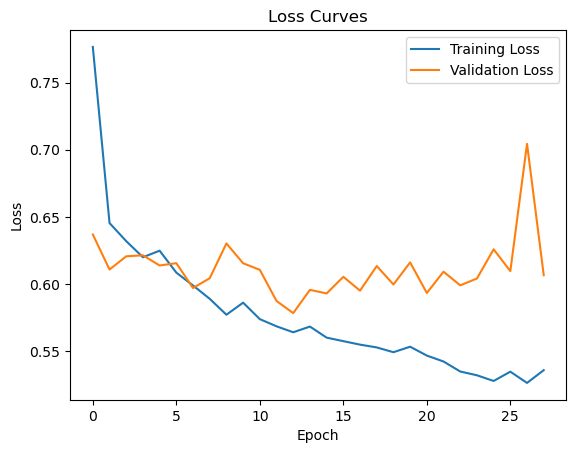

259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6992 - loss: 0.5698
Test Accuracy: 0.6955732703208923
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [2]:
# Define ANN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),  # Input shape should match the shape of the images
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='linear')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)


# Define early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,  # Stop training if no improvement after 15 epochs
    restore_best_weights=True  # Restore weights of the best model
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=200,  # Maximum number of epochs
    batch_size=35,
    callbacks=[early_stopping_callback]  # Add early stopping callback
)

# Plot loss curves for training and validation data
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
_, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Predict on test data
y_pred_nn = model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

In [3]:
# Print the classification report
classification_rep_nn = classification_report(y_test, y_pred_nn_classes, target_names=label_encoder.classes_)
print("Classification Report for ANN Model:")
print(classification_rep_nn)


Classification Report for ANN Model:
              precision    recall  f1-score   support

 Parasitized       0.67      0.75      0.71      4114
  Uninfected       0.72      0.64      0.68      4154

    accuracy                           0.70      8268
   macro avg       0.70      0.70      0.69      8268
weighted avg       0.70      0.70      0.69      8268



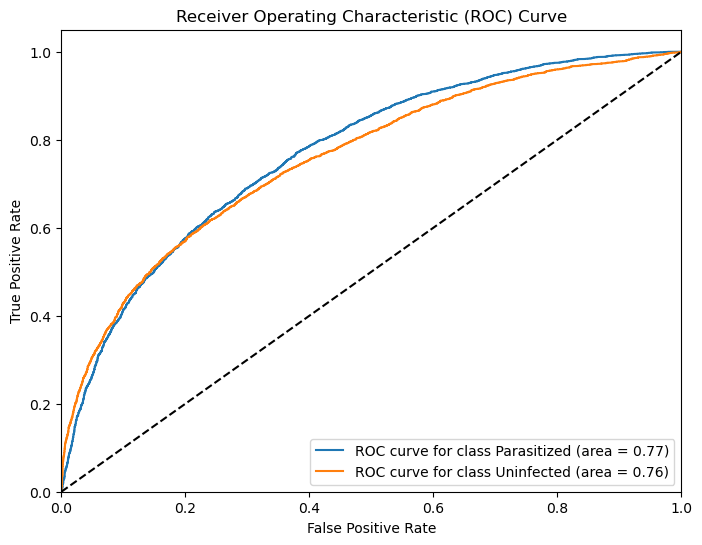

In [4]:
# Plot the ROC curve
plot_roc_curve_multi_class(y_test, y_pred_nn, label_encoder.classes_)

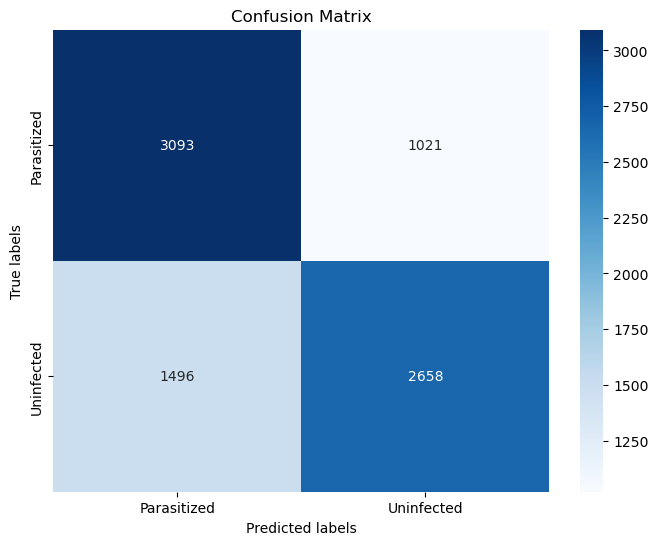

In [5]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred_nn_classes, label_encoder.classes_)

In [6]:
model.save("ANN_without_feature_extraction.h5")

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

import tkinter as tk
from tkinter import ttk, filedialog
from PIL import Image, ImageTk
import numpy as np
from skimage import io, color
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Manually specify class names
class_names = ['Parasitized', 'Uninfected']

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder to the class names
label_encoder.fit(class_names)

# Manually assign encoded labels
label_encoder.classes_ = np.array([0, 1])

# Function to preprocess image
def preprocess_image(image):
    resized_image = cv2.resize(image, (64, 64))
    resized_image = resized_image.astype(np.float32) / 255.0
    return resized_image

# Function to upload and classify an image
def upload_image(label_encoder):
    file_path = filedialog.askopenfilename()
    if file_path:
        # Load the image
        image = io.imread(file_path)

        # Preprocess the image
        preprocessed_image = preprocess_image(image)

        # Make prediction
        predicted_class = model.predict(preprocessed_image.reshape(1, 64, 64, 3))
        
        # Check if prediction is successful
        if predicted_class.size > 0:
            predicted_label = np.argmax(predicted_class)
            predicted_class_name = class_names[predicted_label]
            result_label.config(text=f"The predicted class for the uploaded photo is: {predicted_class_name}")
            
            # Display the image in the middle of the GUI
            update_displayed_image(image)
        else:
            result_label.config(text="Prediction failed")

# Function to load the model
def load_model():
    global model
    model = tf.keras.models.load_model("ANN_without_feature_extraction.h5")
    print("Model loaded successfully.")

# Initialize the Tkinter window
root = tk.Tk()
root.title("Image Classification")

# Create a frame for the main content
main_frame = ttk.Frame(root, padding="20")
main_frame.grid(column=0, row=0)

# Create a label for the title
title_label = ttk.Label(main_frame, text="Image Classification", font=("Arial", 16))
title_label.grid(column=0, row=0, pady=10)

# Function to convert image for display in Tkinter
def convert_image_for_display(image):
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    return image

# Function to update the displayed image
def update_displayed_image(image):
    image = convert_image_for_display(image)
    image_label.config(image=image)
    image_label.image = image

# Create a label to display the uploaded image
image_label = ttk.Label(main_frame)
image_label.grid(column=0, row=1)

# Create a button to upload image
upload_button = ttk.Button(main_frame, text="Upload Image", command=lambda: upload_image(label_encoder))
upload_button.grid(column=0, row=2, pady=10)

# Create a label to display the prediction result
result_label = ttk.Label(main_frame, text="", font=("Arial", 12))
result_label.grid(column=0, row=3, pady=10)

# Set the size of the Tkinter window
window_width = 450
window_height = 400
root.geometry(f"{window_width}x{window_height}")

# Load the model initially
load_model()

# Run the Tkinter event loop
root.mainloop()


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
